In [1]:
import torch
import numpy as np
import cv2
import time
import datetime
import pandas as pd
from PIL import Image
from yolov5.models.experimental import attempt_load
import warnings
warnings.filterwarnings(action = 'ignore')

from convert_data import collect_data, collect_coordinates
from class_mapping import yolo_class_mapping, fire_class_mapping, animals_class_mapping, obstacle_class_mapping
from detection import category
from perform_object import perform_object
from yolo_to_server import send_server
from create_polygon import check_polylist

WARNING ⚠️ 'ultralytics.yolo.v8' is deprecated since '8.0.136' and will be removed in '8.1.0'. Please use 'ultralytics.models.yolo' instead.
WARNING ⚠️ 'ultralytics.yolo.utils' is deprecated since '8.0.136' and will be removed in '8.1.0'. Please use 'ultralytics.utils' instead.
Note this warning may be related to loading older models. You can update your model to current structure with:
    import torch
    ckpt = torch.load("model.pt")  # applies to both official and custom models
    torch.save(ckpt, "updated-model.pt")



### Version check

In [2]:
print('opencv version: ', cv2.__version__)

opencv version:  4.8.0


### Set Trained Models & Camera setting

In [3]:
camera_name = 'KFQ StarValley'
device = torch.device('cpu')

# Load trained YOLOv5 model weights
yolo_weights_path = '/Users/bongeungu/Desktop/kfq/KFQ_TEAM01/yolo/models/yolov5m.pt'
fire_weights_path = '/Users/bongeungu/Desktop/kfq/KFQ_TEAM01/yolo/models/fire_smoke.pt'
animals_weights_path = '/Users/bongeungu/Desktop/kfq/KFQ_TEAM01/yolo/models/animals.pt'
obstacle_weights_path = '/Users/bongeungu/Desktop/kfq/KFQ_TEAM01/yolo/models/obstacle.pt'

yolo_model = attempt_load(yolo_weights_path, device=device)
fire_model = attempt_load(fire_weights_path, device=device)
animals_model = attempt_load(animals_weights_path, device=device)
obstacle_model = attempt_load(obstacle_weights_path, device=device)

Fusing layers... 
YOLOv5m summary: 369 layers, 21190557 parameters, 0 gradients
Fusing layers... 
YOLOv5m summary: 369 layers, 20879400 parameters, 0 gradients, 48.2 GFLOPs
Fusing layers... 
YOLOv5m summary: 369 layers, 20887482 parameters, 0 gradients, 48.3 GFLOPs
Fusing layers... 
YOLOv5m summary: 369 layers, 20887482 parameters, 0 gradients, 48.3 GFLOPs


### Save coordinates for road boundary detection

       X1   Y1    X2   Y2 Class_Name
0    1491  348  1917  684        bus
1    1383  352  1917  693        bus
2    1288  352  1918  708        bus
3    1197  355  1917  709        bus
4    1118  357  1913  710        bus
..    ...  ...   ...  ...        ...
106     1  367   698  717        bus
107     1  367   603  716        bus
108     0  371   496  723        bus
109     1  361   480  727        bus
110     0  380   277  698        bus

[111 rows x 5 columns]
coodrinates count: 111


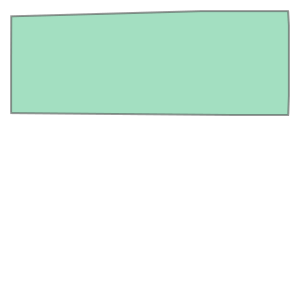

In [5]:
# Initialize webcam
cap = cv2.VideoCapture(0)

columns = ['X1', 'Y1', 'X2', 'Y2', 'Class_Name']
road_coordinates = pd.DataFrame(columns=columns)
sidewalk_coordinates = pd.DataFrame(columns=columns)

for i in range(400):
    ret, frame = cap.read()
    
    image = Image.fromarray(frame)
    image = image.resize((640,640))
    image_tensor = torch.from_numpy(np.array(image)).float().permute(2, 0, 1) / 255.0
    image_tensor = image_tensor.unsqueeze(0).to(device)
    
    results = perform_object(image_tensor, 0.65, yolo_model)
    road_coordinates, sidewalk_coordinates = collect_coordinates(results, frame, yolo_class_mapping, road_coordinates, sidewalk_coordinates)

cap.release()
print(road_coordinates)
print(f'coodrinates count: {len(road_coordinates)}')

# Create road boundary polygon using road coordinates data
polygon = check_polylist(road_coordinates)
polygon

### Object Detection using webcam

In [9]:
# Initialize webcam
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()  # Read frame from the webcam
    captured_time = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S") # 상황 발생 시간 기록
    print(captured_time)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):  # Press 'q' to exit the loop
        break
    
    # reset dataframe
    columns = ['Time', 'Class_Name', 'Confidence', 'X1', 'Y1', 'X2', 'Y2', 'action_detection', 'action_category', 'event_type']
    results_df = pd.DataFrame(columns=columns)
    
    # Preprocess the frame
    image = Image.fromarray(frame)
    image = image.resize((640, 640))  # Resize the image to the model's input size
    image_tensor = torch.from_numpy(np.array(image)).float().permute(2, 0, 1) / 255.0
    image_tensor = image_tensor.unsqueeze(0).to(device)

    # Perform object detection
    results = perform_object(image_tensor, 0.65, yolo_model)
    results_df = collect_data(results, frame, yolo_class_mapping, results_df, captured_time)
    #print(results_df)
    
    results = perform_object(image_tensor, 0.4, fire_model)
    results_df = collect_data(results, frame, fire_class_mapping, results_df, captured_time)
    
    results = perform_object(image_tensor, 0.65, animals_model)
    results_df = collect_data(results, frame, animals_class_mapping, results_df, captured_time)
    
    results = perform_object(image_tensor, 0.4, obstacle_model)
    results_df = collect_data(results, frame, obstacle_class_mapping, results_df, captured_time)
    
    results_df = category(results_df, polygon)
    print(results_df)

    # Display the frame with bounding boxes and labels
    cv2.imshow(camera_name, frame)
    
    #send_server(results_df, camera_name, frame)
    
    time.sleep(2) # 2초 간격으로 사진 캡쳐

# Release the webcam and close windows
cap.release()
cv2.destroyAllWindows()

2023-08-28 14:28:00
state: 1
                  Time Class_Name       Confidence    X1   Y1    X2    Y2  \
0  2023-08-28 14:28:00        car  tensor(0.80955)  1444  623  1916  1077   

   action_detection action_category event_type  
0                 0             NaN        NaN  
2023-08-28 14:28:03
state: 1
state: 1
state: 1
state: 1
state: 1
                  Time Class_Name       Confidence    X1   Y1    X2    Y2  \
0  2023-08-28 14:28:03        car  tensor(0.93385)   612  527  1086   738   
1  2023-08-28 14:28:03     person  tensor(0.79034)   934  937  1026  1079   
2  2023-08-28 14:28:03     person  tensor(0.77274)  1428  408  1509   574   
3  2023-08-28 14:28:03       fire  tensor(0.62521)  1672  665  1916   937   
4  2023-08-28 14:28:03       deer  tensor(0.69632)   901  540  1091   737   

   action_detection            action_category event_type  
0                 0                        NaN        NaN  
1                 1            person detected        P01  
2         

KeyboardInterrupt: 